In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

just some packages you have to download in case you are using twitter sentiment analysis dataset since it contains emojis 

In [3]:
!pip install emoji
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.0 MB/s eta 0:00:00


i am not using embeddings here but you can use if you want to

In [4]:
from gensim.models import Word2Vec

In [5]:
!pip install gensim

load the required dataset and extract value_counts

In [64]:
import pandas as pd
data=pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Train.csv').dropna()#.sample(5000)
data['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

A sample of the data 

In [65]:
data.sample(10)

,text,label
29714,Young Warriors (1983) <br /><br />While this i...,1
16565,Obvious tailored vehicle for Ryan Philippe. It...,0
16329,"Unlike the other spaghetti Westerns, this one ...",0
23081,I really wanted to like this movie - the locat...,0
13172,THE CRIMSON RIVERS is one of the most over-dir...,0
1858,"Oh, well, this movie starts off well. It's kin...",0
15868,"I loved this film, which I have just seen at t...",1
39643,I am frankly surprised how little has been don...,1
25082,Watching this last night it amazed me that Fox...,0
9001,I've been a fan of Xu Ke (Hark Tsui) for many ...,1


the shape of the data

In [66]:
data.shape

(40000, 2)

the following module **cleans** our text column of data 
* it first tokenizes the text
* it lowers the case of each word
* it removes any HTML tags since some are present in our dataset
* it substitutes any extra charcters with white space 
* it also filters out some stopwords from the **stopwords module froim NLTK**




In [67]:
from nltk.corpus import stopwords
import contractions
import string
import emoji
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
def remstopwords(sentence):
    tokenize=list(sentence.split(' '))
    remtokens=[x for x in tokenize if x not in stopwords.words('english') ]
    return (contractions.fix(" ".join(remtokens).lower()))
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)
def preprocess_text(sen):
    sentence = sen.lower()
    sentence = remove_tags(sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  
    sentence = re.sub(r'\s+', ' ', sentence)  
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    tokenize=list(sentence.split(' '))
    return sentence
data['text']=[preprocess_text(x) for x in data['text']]


in this module we convert the text into tokens or indices that the model can understand 
* this is done using the Tokenizer package from tensorflow.keras.preprocessing.text module
* we also find ther length of this word indices to give it as an inout to our Embedding layer later on
* we use fit_on_texts method for extracting the word indices
* then we use text_to_sequences to convert our tokens into indices

In [68]:
from tensorflow.keras.preprocessing.text import Tokenizer
x=0
def token(sentences):
    tokenizer = Tokenizer(num_words=2000,split=' ')
    tokenizer.fit_on_texts(sentences)
    global x
    x=len(tokenizer.word_index) + 1
    word_indices = tokenizer.texts_to_sequences(sentences)
    return word_indices
data['text']=token(data['text'].values)

we can see the word_index length

In [69]:
x

92131

split the data into X and Y sets

In [70]:
X=data.drop(columns=['label'])
Y=data['label']#.map({'positive':1,'negative':0})

pad the index sequences in X to a particular length here i am using 200

In [71]:
X=pad_sequences(X['text'],padding='post',maxlen=200)

In [73]:
from sklearn.model_selection import train_test_split

import  train_test_split module from sklearn and use it to split the data into train and test sets
i am not using stratified shuffel split because the counts of 0,1 are almodst comparible

In [74]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.3,random_state=42)

import the modules required to us to build the model

In [88]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,SpatialDropout1D,Bidirectional, Dropout, Conv1D, Flatten, Input
from keras.regularizers import L2

define a regularization parameter i have found L2 to work best you can try around

In [76]:
reg=L2(l2=0.01)

here we define out model

In [116]:
model=Sequential()
model.add(Input(shape=(200,)))
model.add(Embedding(input_dim=x,output_dim=50,trainable=True, embeddings_regularizer=reg))
#model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(50,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.33))
#model.add(Dense(40, activation='relu',kernel_regularizer=reg))
model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ (None, 200, 50)        │     4,606,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 200, 100)       │        40,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        34,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,686,849 (17.88 MB)

 Trainable params: 4,686,849 (17.88 MB)

 Non-trainable params: 0 (0.00 B)

we can clearly see the model architecture in the below output

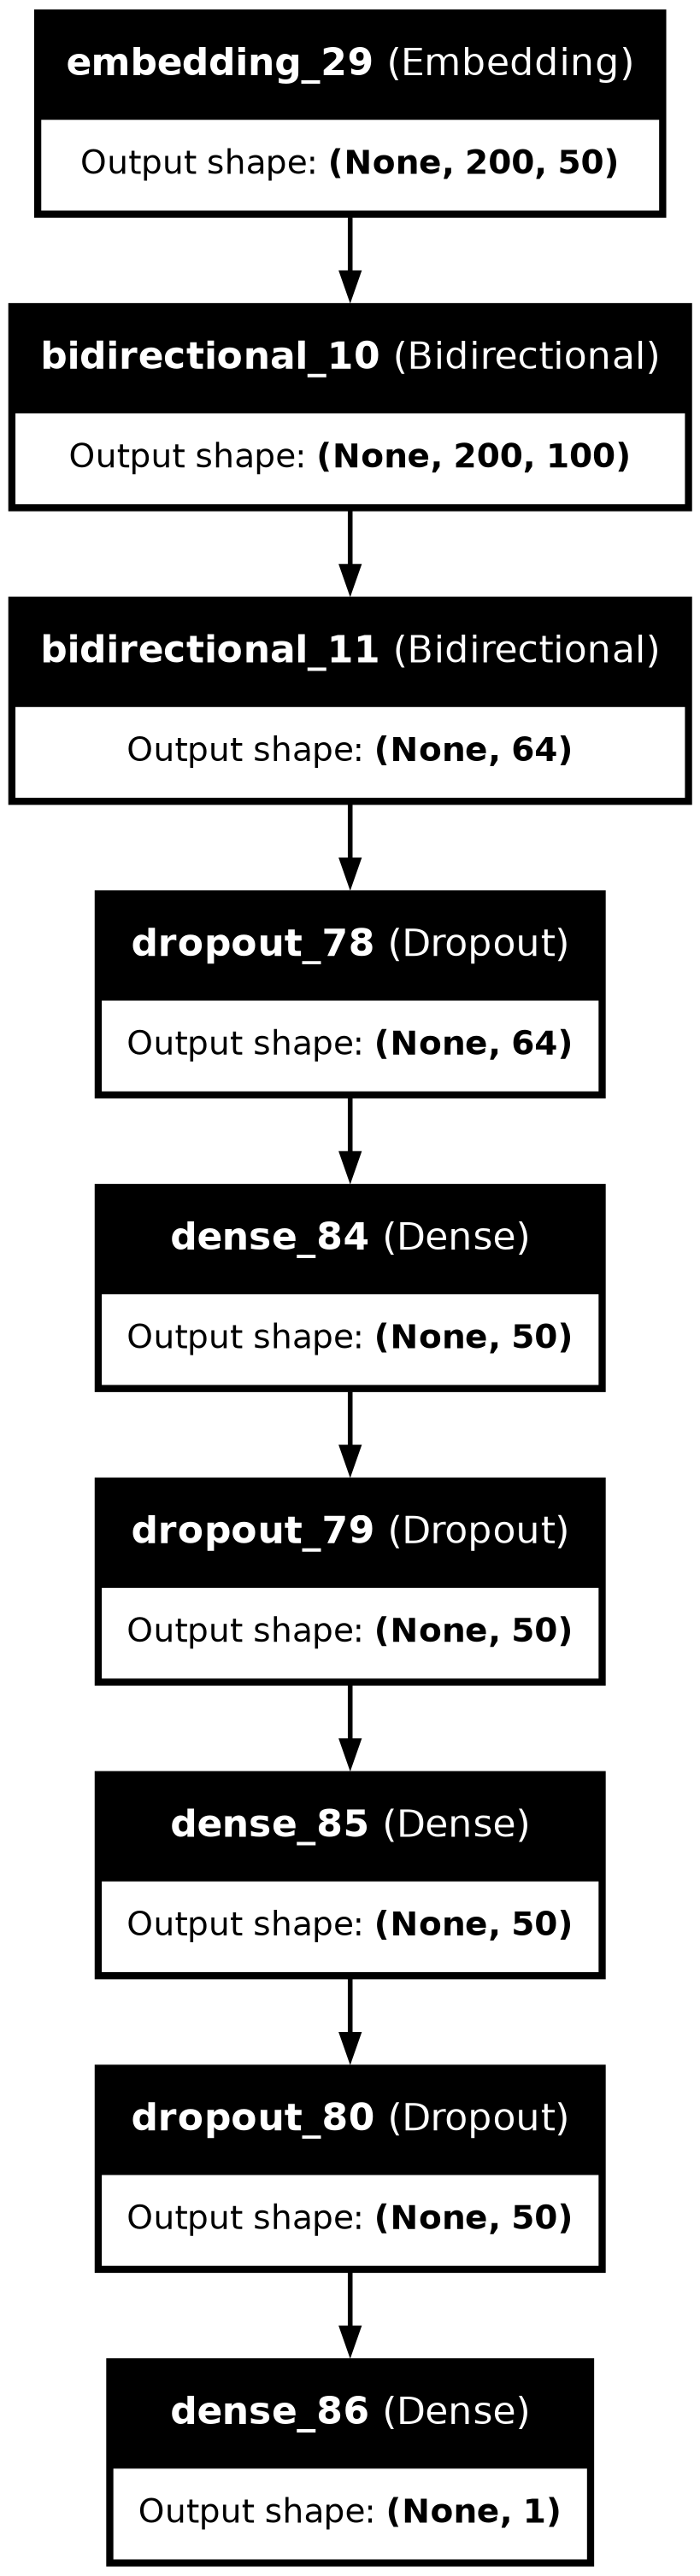

In [121]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True)

i am defining early stopping on val_loss since i found it was overfitting

In [117]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss', patience=3) 

running the model for 30 epochs 

In [118]:
histr=model.fit(xtrain,ytrain,epochs=30, batch_size=256,validation_data=(xtest,ytest), callbacks=[early])

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4957 - loss: 13.8995 - val_accuracy: 0.4970 - val_loss: 0.6941
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.5023 - loss: 0.6935 - val_accuracy: 0.6322 - val_loss: 0.6793
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.7473 - loss: 0.5794 - val_accuracy: 0.8435 - val_loss: 0.4398
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8604 - loss: 0.4240 - val_accuracy: 0.8682 - val_loss: 0.3824
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8740 - loss: 0.3817 - val_accuracy: 0.8550 - val_loss: 0.3853
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.8767 - loss: 0.3641 - val_accuracy: 0.8608 - val_loss: 0.3766
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.8888 - loss: 0.3410 - val_accuracy: 0.8724 - val_loss: 0.3677
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8863 - loss: 0.3379 - val_ac

plot between accuracy and val_accuracy

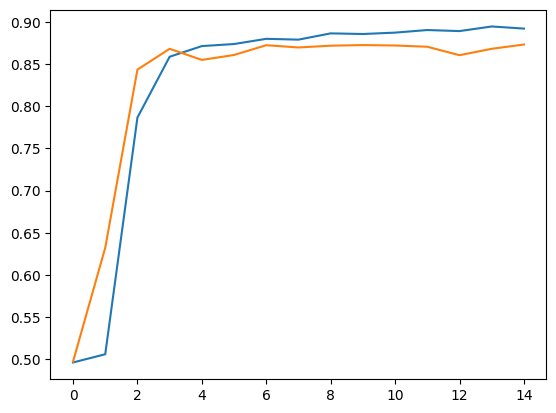

In [119]:
import matplotlib.pyplot as plt
plt.plot(histr.history['accuracy'])
plt.plot(histr.history['val_accuracy'])

there is a lot of room for improvement you can explore and try it out!!